<a href="https://colab.research.google.com/github/icekang/NLP_2021/blob/main/hw5_thai_skip_gram_homework_for_student_v2020s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [ ]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [ ]:
!wget https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
!wget https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
!unzip wiki.zip

!unzip BEST-TrainingSet.zip

--2021-02-21 14:42:45--  https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eexden7246sgfzf/BEST-TrainingSet.zip [following]
--2021-02-21 14:42:46--  https://www.dropbox.com/s/raw/eexden7246sgfzf/BEST-TrainingSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb71c975f0df6a64784dc9a458a.dl.dropboxusercontent.com/cd/0/inline/BJXZFDvX7A-m3boFwFkLTtFD5PGwTGgsaRLOweTlyOyNAAVLTrCWlpBMFHBFiJ7NR261gpej6GMnwoP8EEF770U2LY-hYsmNOOTvVxAqrArbsMv94kDt3yG1YdABeaqLm9g/file# [following]
--2021-02-21 14:42:46--  https://ucb71c975f0df6a64784dc9a458a.dl.dropboxusercontent.com/cd/0/inline/BJXZFDvX7A-m3boFwFkLTtFD5PGwTGgsaRLOweTlyOyNAAVLTrCWlpBMFHBFiJ7NR261gpej6GMnwoP8EEF7

In [ ]:
#Step 1: read the wikipedia text file
with open("wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [ ]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color=''>Homework Question 1:</font>
<font color=''>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color=''>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [ ]:
import matplotlib.pyplot as plt

word_count_global = None
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text, min_thres_unk = 0, max_word_count = None):
    global word_count_global
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    word_count.append(("UNK",0))
    word_count_global = word_count

    #print out 10 most frequent words
    print(word_count[:10])

    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word, count in word_count:
      if count > min_thres_unk or word == 'UNK':
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
      if word not in dictionary:
        data.append(dictionary['UNK'])
      else:
        data.append(dictionary[word])

    return data,dictionary, reverse_dictionary

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 3)
print(len(dataset))
print(len(dictionary))

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]
36349066
153544


## Explain
I plot frequency of words to see what threshold shall I cut<br>
Here, I chose `threshold 3` 78.0% (of words)<br>
because after this number of words increase by only 1 percent which, to me, is not significant.

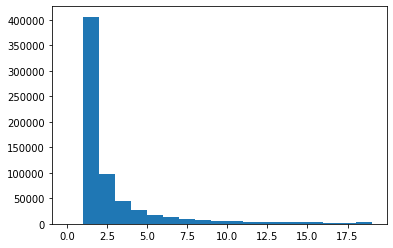

In [ ]:
bins = plt.hist([c for w,c in word_count_global], range(0,20))
plt.show()

In [ ]:
N = 701356
for i in range(1,20):
  n = sum(bins[0][1:i])
  print('threshold', i-1, n, f'{10000 * n / N // 100}%')

threshold 0 0 0.0%
threshold 1 406192.0 57.0%
threshold 2 503531.0 71.0%
threshold 3 547812.0 78.0%
threshold 4 574133.0 81.0%
threshold 5 591453.0 84.0%
threshold 6 604487.0 86.0%
threshold 7 614252.0 87.0%
threshold 8 621916.0 88.0%
threshold 9 628181.0 89.0%
threshold 10 633380.0 90.0%
threshold 11 637842.0 90.0%
threshold 12 641602.0 91.0%
threshold 13 644887.0 91.0%
threshold 14 647841.0 92.0%
threshold 15 650431.0 92.0%
threshold 16 652804.0 93.0%
threshold 17 654832.0 93.0%
threshold 18 658550.0 93.0%


In [ ]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color=''>Homework Question 2:</font>
<font color=''>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color=''>Q2: PUT YOUR ANSER HERE!!!</font><br>
Keras tries to decrease probabilty of words of high frequency, while in the class, we try to increase that of words of low frequency.

In [ ]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
  print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])

[[208, 41854], [208, 2453], [2453, 573], [208, 117758], [24, 681], [2453, 208], [3124, 72927], [2453, 57788], [24, 1704], [208, 229], [3124, 681], [3124, 7149], [3124, 142854], [2453, 109975]] [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
หลัก ซัมเมอร์ส
หลัก วิกิพีเดีย
วิกิพีเดีย ดำเนินการ
หลัก คอนเวอร์เตอร์
ไม่ องค์กร
วิกิพีเดีย หลัก
มีเดีย เหรียญศาร
วิกิพีเดีย แวร์ซาย


# Step 4: create the skip-gram model
## <font color=''>Homework Question 3:</font>
 <font color=''>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='red'>Q3: PUT YOUR ANSER HERE!!!</font>
 <br>
 First of all, it is memory friendly. No matter how we calculate cosine similarity of a pair of words. The output is only one number instead of N-dim vector.<br>
 In addition, loss function uses log which make much more sense with [0,1] for probability rather than relu [0,inf) or tanh [-1,1]

In [ ]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        4913440     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        4913440     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# currently the dataset is 1/20 of the full text file.
multiplier = 100000
for _ in range(2):
    prev_i=0
    #it is likely that your GPU won't be able to handle large input
    #just do it 100000 words at a time
    for i in range(len(dataset)//multiplier):
        #generate skipgrams
        data, labels = skipgrams(sequence=dataset[prev_i*multiplier:(i*multiplier)+multiplier], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
            SkipGram.save_weights(f'/content/drive/MyDrive/hw5-skipgram/my_skipgram32_weights-hw-{i*multiplier}-{loss}.h5')
        prev_i = i 
        print(loss,i*multiplier)


0.6931530237197876 0
0.6931214332580566 100000
0.6930861473083496 200000
0.6930124759674072 300000
0.6928961277008057 400000
0.6927148699760437 500000
0.6924630403518677 600000
0.6921004056930542 700000
0.691530168056488 800000
0.6908166408538818 900000
0.6899302005767822 1000000
0.6886997222900391 1100000
0.6873592734336853 1200000
0.6853577494621277 1300000
0.683154821395874 1400000
0.6809923052787781 1500000
0.6776577234268188 1600000
0.6737194061279297 1700000
0.6692689657211304 1800000
0.6647663116455078 1900000
0.6600084900856018 2000000
0.6530169248580933 2100000
0.645172655582428 2200000
0.6374605894088745 2300000
0.628936231136322 2400000
0.6202719807624817 2500000
0.6108173131942749 2600000
0.6020578145980835 2700000
0.591934323310852 2800000
0.578183650970459 2900000
0.5638103485107422 3000000
0.5502883195877075 3100000
0.5370844602584839 3200000
0.5254123210906982 3300000
0.5098598003387451 3400000
0.49096444249153137 3500000
0.4756113588809967 3600000
0.4601725935935974 37

In [ ]:
# SkipGram.save_weights('my_skipgram32_weights-hw.h5')
SkipGram.load_weights('/content/drive/MyDrive/hw5-skipgram/my_skipgram32_weights-hw.h5')
# SkipGram.load_weights('/content/drive/MyDrive/hw5-skipgram/my_skipgram32_weights-hw-33900000-0.13447827100753784.h5')

In [ ]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[-0.01860917  0.01938124  0.0207364  ...  0.01218445  0.00212651
   0.01375028]
 [-0.49981844  0.41046733 -0.59824306 ...  0.5241086  -0.5860986
   0.5765467 ]
 [-0.50383323  0.28770196 -0.45041224 ...  0.4926264  -0.5751475
   0.6041441 ]
 ...
 [ 0.02654959  0.02232834 -0.04700992 ...  0.01880474  0.02930037
  -0.02829891]
 [ 0.03735652  0.00350807 -0.01710014 ...  0.04450684  0.00997959
   0.03114747]
 [-0.46685266  0.44005847 -0.47300085 ...  0.4222149  -0.5279841
   0.52296746]]
(153545, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 4: </font>
<font color='blue'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings </font>


In [ ]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings 
#and tell us what you observe 

import scipy.spatial
s = [
     ('แมว','หมา','สิงโต'),
     ('ดี','ขาว','ดำ'),
     ('โตเกียว','ญี่ปุ่น','ไทย'),
     ('king','man', 'woman'),
     ('ขอทาน','จน','รวย'),
     ('เพลง','ศิลปิน','ทหาร'),
     ('งง','โง่','ฉลาด'),
     ('ล้น','มาก','น้อย'),
     ('ชอบ','รัก','หลง'),
     ('กษัตริย์','ชาย','หญิง')
    ]
for i in s:
  tmp = (final_embeddings[dictionary[i[0]]]-final_embeddings[dictionary[i[1]]]+final_embeddings[dictionary[i[2]]]).reshape(1,-1)
  all_dist = scipy.spatial.distance.cdist(final_embeddings, tmp, 'cosine').reshape(-1)
  idx = np.argpartition(all_dist,1)[:1][0]
  # print(reverse_dictionary[idx])
  # idx = idx[np.argsort(all_dist[idx[:3]])]
  # for i in idx:
  print(i[0],'-',i[1],'+',i[2],'=',reverse_dictionary[idx])
  print('===========')

แมว - หมา + สิงโต = สิงโต
เหลือง - แดง + เขียว = เหลือง
โตเกียว - ญี่ปุ่น + ไทย = อคติ
king - man + woman = ฮนโนจิ
ขอทาน - จน + รวย = who
เพลง - ศิลปิน + ทหาร = เถรวาท
งง - โง่ + ฉลาด = ญาณ
ล้น - มาก + น้อย = จอร์จ
ชอบ - รัก + หลง = หลง
กษัตริย์ - ชาย + หญิง = เอสปา


The embedding can not catch the meaning of the word that much, yet <br>
`กษัตริย์ - ชาย + หญิง = เอสปา` is kinda cool, becase `เอสปา` is girl group and might be "queen" for their fans <br>
`งง - โง่ + ฉลาด = ญาณ` is also cool, since `ญาณ` is `ปัญญา` in Buddhism<br>

# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question5:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [ ]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [ ]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [ ]:
val_input

array([[153544,  25982,    207, ..., 153544, 153544,   1089],
       [  3382,     39,      1, ...,    202,    130,     13],
       [  8544,    156,     41, ...,   5572,     58,    759],
       ...,
       [  4313,    907,   1273, ...,  23587,    444,     87],
       [    74,     55,   5659, ...,    510,    266,    203],
       [    27,     17,    750, ...,      1,     50,      8]], dtype=int32)

In [ ]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          4913440   
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 4,919,908
Trainable params: 4,919,908
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 30s 2s/step - loss: 1.3609 - accuracy: 0.3361 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 1.1892 - accura

In [ ]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 1s 111ms/step - loss: 2.4041 - accuracy: 0.4804
test loss, test acc: [2.4041450023651123, 0.4803921580314636]


In [ ]:
cls_model_with_pretrained_weight = Sequential()
cls_model_with_pretrained_weight.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True, embeddings_initializer=tf.keras.initializers.Constant(final_embeddings)))
cls_model_with_pretrained_weight.add(GRU(32))
cls_model_with_pretrained_weight.add(Dropout(0.5))
cls_model_with_pretrained_weight.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model_with_pretrained_weight.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model_with_pretrained_weight.summary()
print('Train...')
cls_model_with_pretrained_weight.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 32)          4913440   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 4,919,908
Trainable params: 4,919,908
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 1.4493 - accuracy: 0.3623 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 1.4477 - accu

In [ ]:
results = cls_model_with_pretrained_weight.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 1s 98ms/step - loss: 1.2922 - accuracy: 0.6176
test loss, test acc: [1.292184591293335, 0.6176470518112183]


### Discussion
With pretrained weight, model converge better.<br>
However the same analogy we used seem to be confusing now...


In [ ]:
model_final_embeddings = cls_model.layers[0]
model_final_embeddings_with_pretrained_weight = cls_model_with_pretrained_weight.layers[0]

In [ ]:
print('Without pretrain')
result_embedding = model_final_embeddings.weights[0].numpy()
for i in s:
  tmp = (result_embedding[dictionary[i[0]]]-result_embedding[dictionary[i[1]]]+result_embedding[dictionary[i[2]]]).reshape(1,-1)
  all_dist = scipy.spatial.distance.cdist(result_embedding, tmp, 'cosine').reshape(-1)
  idx = np.argpartition(all_dist,1)[:1][0]
  # print(reverse_dictionary[idx])
  # idx = idx[np.argsort(all_dist[idx[:3]])]
  # for i in idx:
  print(i[0],'-',i[1],'+',i[2],'=',reverse_dictionary[idx])
  print('===========')
print('\n\n')
print('With pretrain')
result_embedding = model_final_embeddings_with_pretrained_weight.weights[0].numpy()
for i in s:
  tmp = (result_embedding[dictionary[i[0]]]-result_embedding[dictionary[i[1]]]+result_embedding[dictionary[i[2]]]).reshape(1,-1)
  all_dist = scipy.spatial.distance.cdist(result_embedding, tmp, 'cosine').reshape(-1)
  idx = np.argpartition(all_dist,1)[:1][0]
  # print(reverse_dictionary[idx])
  # idx = idx[np.argsort(all_dist[idx[:3]])]
  # for i in idx:
  print(i[0],'-',i[1],'+',i[2],'=',reverse_dictionary[idx])
  print('===========')

Without pretrain
แมว - หมา + สิงโต = งดงาม
ดี - ขาว + ดำ = หรอก
โตเกียว - ญี่ปุ่น + ไทย = ไทย
king - man + woman = เอตู๊ด
ขอทาน - จน + รวย = ม่าย
เพลง - ศิลปิน + ทหาร = ตั้ง
งง - โง่ + ฉลาด = งง
ล้น - มาก + น้อย = น้อย
ชอบ - รัก + หลง = กรุงเทพประกันภัย
กษัตริย์ - ชาย + หญิง = รัฐธรรมนูญ



With pretrain
แมว - หมา + สิงโต = ผัด
ดี - ขาว + ดำ = เดินทาง
โตเกียว - ญี่ปุ่น + ไทย = อาศัย
king - man + woman = และอาย
ขอทาน - จน + รวย = สน
เพลง - ศิลปิน + ทหาร = เพลง
งง - โง่ + ฉลาด = ฉลาด
ล้น - มาก + น้อย = ลายลักษณ์อักษร
ชอบ - รัก + หลง = หลง
กษัตริย์ - ชาย + หญิง = รอบคอบ
